Import Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
mb_raw_data = pd.read_csv('/content/drive/MyDrive/mann_bruker.txt', sep='\t')

In [8]:
import tensorflow as tf

# Enable GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Rest of your code


Found GPU at: /device:GPU:0


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold,learning_curve
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import matplotlib.pyplot as plt
import time
from scipy import stats


# Keep only necessary columns
mb_clean_frame = mb_raw_data[['Sequence', 'm/z', 'CCS','Mass','Charge','Length']]

# Perform z-score transformation
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

# Save the mean and std for later use
ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

# Delete the raw data frame to save memory

# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

# Split the data into input (m/z) and output (CCS) variables
X = mb_clean_frame[['Mass', 'Charge', 'Length']]
y = mb_clean_frame['CCS_z']


<ipython-input-10-db7c46125395>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from sklearn.model_selection import train_test_split

# Reshape the data for CNN
X = X.values.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
progress_bar = ProgbarLogger(count_mode='steps', stateful_metrics=None)

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping, progress_bar])


Epoch 1/100
11020/11020 [==============================] - 54s 4ms/step - loss: 21.7454 - val_loss: 0.9089
Epoch 2/100
11020/11020 [==============================] - 46s 4ms/step - loss: 0.3866 - val_loss: 1.1135
Epoch 3/100
11020/11020 [==============================] - 41s 4ms/step - loss: 0.1735 - val_loss: 0.2422
Epoch 4/100
11020/11020 [==============================] - 48s 4ms/step - loss: 0.1079 - val_loss: 0.0265
Epoch 5/100
11020/11020 [==============================] - 42s 4ms/step - loss: 0.0581 - val_loss: 0.0805
Epoch 6/100
11020/11020 [==============================] - 43s 4ms/step - loss: 0.0359 - val_loss: 0.1793
Epoch 7/100
11020/11020 [==============================] - 43s 4ms/step - loss: 0.0232 - val_loss: 0.0137
Epoch 8/100
11020/11020 [==============================] - 47s 4ms/step - loss: 0.0178 - val_loss: 0.0300
Epoch 9/100
11020/11020 [==============================] - 43s 4ms/step - loss: 0.0167 - val_loss: 0.0115
Epoch 10/100
11020/11020 [===================

2755/2755 [==============================] - 6s 2ms/step


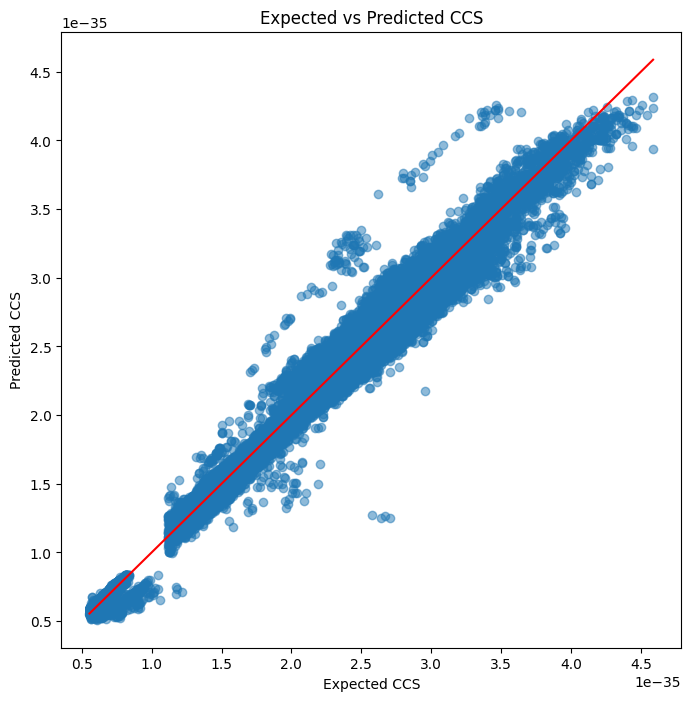

In [12]:
# Get predictions
y_pred = model.predict(X_test)
import matplotlib.pyplot as plt

# Convert z-scores back to original scale
y_test_orig = y_test * ccs_std + ccs_mean
y_pred_orig = y_pred * ccs_std + ccs_mean

plt.figure(figsize=(8, 8))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.xlabel('Expected CCS')
plt.ylabel('Predicted CCS')
plt.title('Expected vs Predicted CCS')
plt.plot([min(y_test_orig), max(y_test_orig)], [min(y_test_orig), max(y_test_orig)], color='red') # A red line showing perfect fit
plt.show()
